In [73]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure

import random
import copy
import math
import cv2
import os

from IPython.display import clear_output

In [74]:
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Thu Feb  1 23:56:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:1A:00.0 Off |                  Off |
| 30%   31C    P8    17W / 230W |  23427MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+--

In [81]:
idx = 10

div = 32
step = int(32/4)
red = [4, 4, 2, 1, 2, 4, 6, 4, 8, 8, 4] # Check the estimated_scales.yaml -> the resolution has to be 0.4 meters/pixel
# coupa0 e 3   ->     red = 15
# gates2       ->     red = 11 o 10 (10)
# hyang1       ->     red = 5
# hyang10      ->     red = 8
red = red[idx]
location_list = ['coupa', 'coupa', 'gates', 'hyang', 'hyang', 'nexus', 'little', 'nexus', 'coupa', 'coupa', 'hyang']
number_list = ['0', '3', '2', '1', '10', '0', '3', '1', '1', '2', '0']

sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree','restricted','grass','intersection']
chans = len(sem_dict)+1

lut_in = [0, 20, 50, 100, 150, 255]
lut_out = [0, 100, 180, 220, 240, 255]
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

location = location_list[idx]
number = number_list[idx]
map_name = 'stanford_'+location+number
directory_dataset = '/'+location+'/video'+number+'/'

In [76]:
# model = tf.keras.models.load_model('IRI_models/4set_8px_steps_only_paths')

# model1 = tf.keras.models.load_model('IRI_models/4set_8px_steps_only_vels')

# model2 = tf.keras.models.load_model('IRI_models/4set_8px_steps_only_stops')

In [77]:
# print(map_name)

# lines = 0
# with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
#   lines = f.readlines()

# h = len(lines)
# w = len(lines[0].split(','))

# # Converts data to a list of integers
# map_var = []
# for line in lines:
#   map_var.extend([int(c) for c in line.split(',')])

# for lab_class in sem_dict:
#   lines = 0
#   try:
#     with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
#       lines = f.readlines()

#     hh = len(lines)
#     ww = len(lines[0].split(','))

#     if hh != h or ww != w:
#       print(f'h: {h}\tw: {w}')
#       print(f'h: {hh}\tw: {ww}')
#       raise SystemExit("ERROR: Different sizes!!")

#     # Converts data to a list of integers
#     for line in lines:
#       map_var.extend([int(c) for c in line.split(',')])

#   except FileNotFoundError:
#     for i in range(h):
#       for j in range(w):
#         map_var.extend([255])

# map_var = np.reshape(map_var,[chans,h,w])
# map_var = np.moveaxis(map_var, 0, -1)
# map_var = map_var/255

# print(map_var.shape)

# map_aux = map_var
# map_var = np.zeros((int(math.ceil(h/red)),int(math.ceil(w/red)),chans))

# for idx in range(chans):
#   map_var[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (red,red), np.min)
# h, w, _ = map_var.shape

# np.savetxt('maps/semantics/'+map_name+'/'+map_name+'-reduced.csv', map_var[:,:,0]*255, delimiter=',', fmt='%3d')
# for index, lab_class in enumerate(sem_dict):
#   np.savetxt('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'-reduced.csv', map_var[:,:,index+1]*255, delimiter=',', fmt='%3d')

# print(sem_dict)
# plt.figure(figsize=(20,5))
# for i in range(len(sem_dict)):
#   ax = plt.subplot(1, len(sem_dict), i+1)
#   alp = 0.5
#   ax.imshow(np.multiply(np.stack((map_var[:,:,0],map_var[:,:,0],map_var[:,:,0]),axis=2),np.stack((map_var[:,:,i+1],map_var[:,:,i+1],map_var[:,:,i+1]),axis=2)*alp+(1-alp)), vmin=0, vmax=1)
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)
# plt.show()

(1080, 816, 3)


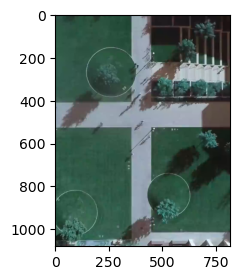

In [82]:
# Code to check if the red variable is correct to scale to the correct homography. Check on google maps and note that each pixel should be 0.4 meters (32 pixels = 12.8m)

cap = cv2.VideoCapture('Stanford_Drone_Dataset/video'+directory_dataset+'video.mp4')
df = pd.read_csv('Stanford_Drone_Dataset/annotations'+directory_dataset+'annotations.txt', delimiter=' ', header=None)
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
ret, frame = cap.read()
print(frame.shape)

frame = skimage.measure.block_reduce(frame, (red,red,1), np.max)

plt.figure(figsize=(3,3))
im = plt.imshow(frame)
ax = plt.gca()
# ax.set_xticks(np.arange(0, 170, 5))
# ax.set_yticks(np.arange(0, 90, 5))
plt.show()


In [79]:
cap = cv2.VideoCapture('Stanford_Drone_Dataset/video'+directory_dataset+'video.mp4')
df = pd.read_csv('Stanford_Drone_Dataset/annotations'+directory_dataset+'annotations.txt', delimiter=' ', header=None)
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
ret, frame = cap.read()
cv2.imwrite('maps/semantics/'+map_name+'/reference.png', frame)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ref_frame = frame

h = frame.shape[0]
w = frame.shape[1]

dt = 1/cap.get(cv2.CAP_PROP_FPS)

data = np.zeros((h,w))
data_vel = np.zeros((h,w))
data_stops = np.zeros((h,w))
pos = np.full(len(df[0].unique()), {'x': 0.0, 'y': 0.0})
vels = np.full(len(df[0].unique()), {'x': 0.0, 'y': 0.0})

ratioy = (df[4].max())/h
ratiox = (df[3].max())/w

frame_count = 0
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    if frame_count % 1 == 0:
 
      ce = df[df[5]==frame_count] # current elements in frame (people and bikes)
      ce = ce[ce[9]=='Pedestrian']# filter only people

      vel_temp = np.zeros((h,w))
      for i in ce.index:
        el = ce.loc[i]

        # color = (255, 0, 0)
        # hcolor = (255, 255, 0)
        # radius = 10
        # thickness = -1
        
        alpha = 0.2

        centerOfCircle = (int((el[2]+el[4])/2/ratioy),int((el[1]+el[3])/2/ratiox))
        if(pos[el[0]]['x']==0 and pos[el[0]]['y']==0):
          pos[el[0]] = {'x': centerOfCircle[0],'y': centerOfCircle[1]}
        vels[el[0]] = {'x': alpha*0.015*(centerOfCircle[0]-pos[el[0]]['x'])/dt + (1-alpha)*vels[el[0]]['x'],'y': alpha*0.015*(centerOfCircle[1]-pos[el[0]]['y'])/dt + (1-alpha)*vels[el[0]]['y']}
        pos[el[0]] = {'x': centerOfCircle[0],'y': centerOfCircle[1]}

        if centerOfCircle[0] < h and centerOfCircle[1] < w and el[6] == 0 or el[7] == 1:
          data[centerOfCircle] = data[centerOfCircle] + 1
          vel_temp[centerOfCircle] = math.sqrt(vels[el[0]]['x']**2+vels[el[0]]['y']**2)
          if(vel_temp[centerOfCircle] < 0.1):
            data_stops[centerOfCircle] = data_stops[centerOfCircle] + 1
          #   frame = cv2.circle(frame, (centerOfCircle[1],centerOfCircle[0]), radius, hcolor, thickness)
          # else:
          #   frame = cv2.circle(frame, (centerOfCircle[1],centerOfCircle[0]), radius, color, thickness)
          # frame = cv2.putText(frame, "{:.3f}".format(vel_temp[centerOfCircle]), (centerOfCircle[1],centerOfCircle[0]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

      data_vel = data_vel * (vel_temp == 0) + data_vel * (vel_temp > 0)*0.5 + vel_temp * (data_vel > 0)*0.5 + vel_temp * (data_vel == 0)

      # # Display the resulting frame
      # clear_output(wait=True)
      # plt.figure(figsize=(1956/100,1080/100))
      # plt.imshow(frame)
      # plt.show()
    
    frame_count = frame_count + 1
 
  # Break the loop
  else: 
    
    break
 
# When everything done, release the video capture object
cap.release()

record_data = data
record_data_vel = data_vel
record_data_stops = data_stops

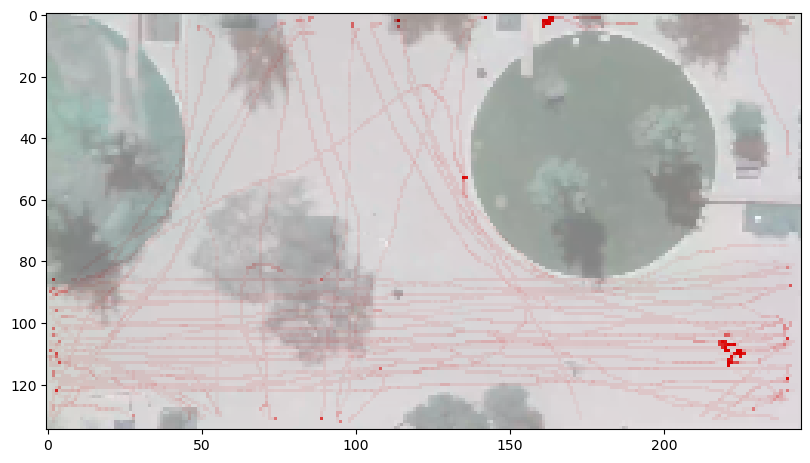

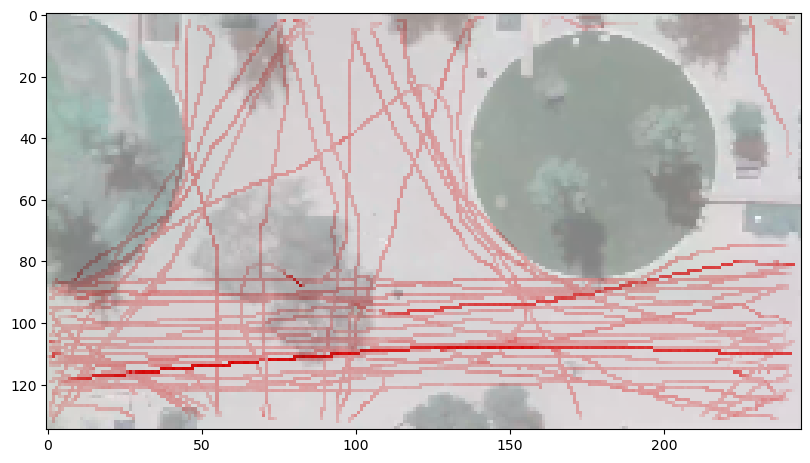

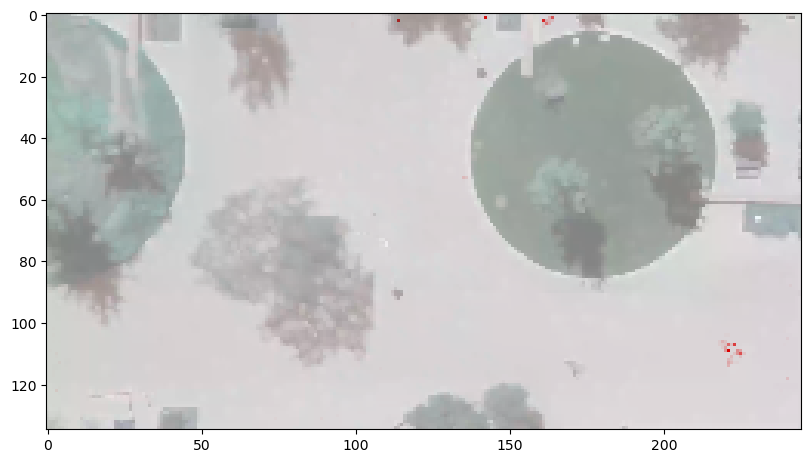

In [80]:
data = record_data
data_vel = record_data_vel
data_stops = record_data_stops

data = np.clip(data,0,np.max(data)*0.2)/(np.max(data)*0.2)
data = cv2.LUT((data/np.max(data)*255).astype(np.uint8), lut_8u).astype(float)/255
data = skimage.measure.block_reduce(data, (red,red), np.max)
ref_frame_red = skimage.measure.block_reduce(ref_frame, (red,red,1), np.max)/510+0.5
data = np.subtract(data, np.full((data.shape[0], data.shape[1]), np.min(data)))/(np.max(data)-np.min(data))

plt.figure(figsize=(w/200,h/200))
# plt.imshow(np.multiply(np.stack((map_var[:,:,0],map_var[:,:,0],map_var[:,:,0]),axis=2), np.stack((np.full(data.shape,1),1-data,1-data),axis=2)))
plt.imshow(np.multiply(ref_frame_red, np.stack((np.full(data.shape,1),1-data,1-data),axis=2)))
plt.show()

np.savetxt('maps/semantics/'+map_name+'/humandensity-'+map_name+'-new.csv', data*255, delimiter=',', fmt='%3d')

# -----------------------------------------------------------------------------------

data_vel = skimage.measure.block_reduce(data_vel, (red,red), np.max)
data_vel = np.subtract(data_vel, np.full((data.shape[0], data.shape[1]), np.min(data_vel)))/(np.max(data_vel)-np.min(data_vel))

plt.figure(figsize=(w/200,h/200))
# plt.imshow(np.multiply(np.stack((map_var[:,:,0],map_var[:,:,0],map_var[:,:,0]),axis=2), np.stack((np.full(data_vel.shape,1),1-data_vel,1-data_vel),axis=2)))
plt.imshow(np.multiply(ref_frame_red, np.stack((np.full(data_vel.shape,1),1-data_vel,1-data_vel),axis=2)))
plt.show()

np.savetxt('maps/semantics/'+map_name+'/humandensity-'+map_name+'-vel.csv', data_vel*255, delimiter=',', fmt='%3d')

# -----------------------------------------------------------------------------------

data_stops = skimage.measure.block_reduce(data_stops, (red,red), np.max)
data_stops = np.subtract(data_stops, np.full((data.shape[0], data.shape[1]), np.min(data_stops)))/(np.max(data_stops)-np.min(data_stops))

plt.figure(figsize=(w/200,h/200))
# plt.imshow(np.multiply(np.stack((map_var[:,:,0],map_var[:,:,0],map_var[:,:,0]),axis=2), np.stack((np.full(data_stops.shape,1),1-data_stops,1-data_stops),axis=2)))
plt.imshow(np.multiply(ref_frame_red, np.stack((np.full(data_stops.shape,1),1-data_stops,1-data_stops),axis=2)))
plt.show()

np.savetxt('maps/semantics/'+map_name+'/humandensity-'+map_name+'-stop.csv', data_stops*255, delimiter=',', fmt='%3d')